<h1 style="color:#444; font-size:2.5em;">Skill Connect: Week 1 - Advanced Challenge</h1>

# 3. Linear Regression

In [1]:
import torch                                  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt               
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from IPython.core.debugger import set_trace

sns.set(rc={"figure.figsize":(20,10)})

## Get the data

In [2]:
data = load_boston()
X = data['data']
y = data['target']

n = X.shape[1] # number of features

df = pd.DataFrame(np.concatenate([X.T,y.reshape(-1,1).T]).T,columns=[*data['feature_names'],"PRICE"])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Preprocess the data

In [3]:
X_tr, X_te, y_tr,y_te = train_test_split(X,y,shuffle=True, train_size=0.8, stratify=y//5)

def znorm(d,mean,std):
    return (d - mean)/std 

X_mean = X_tr.mean(axis=0)
X_std = X_tr.std(axis=0)

y_mean = y_tr.mean(axis=0)
y_std = y_tr.std(axis=0)

X_tr, X_te = znorm(X_tr,X_mean,X_std),znorm(X_te,X_mean,X_std)
y_tr, y_te = znorm(y_tr,y_mean,y_std),znorm(y_te,y_mean,y_std)

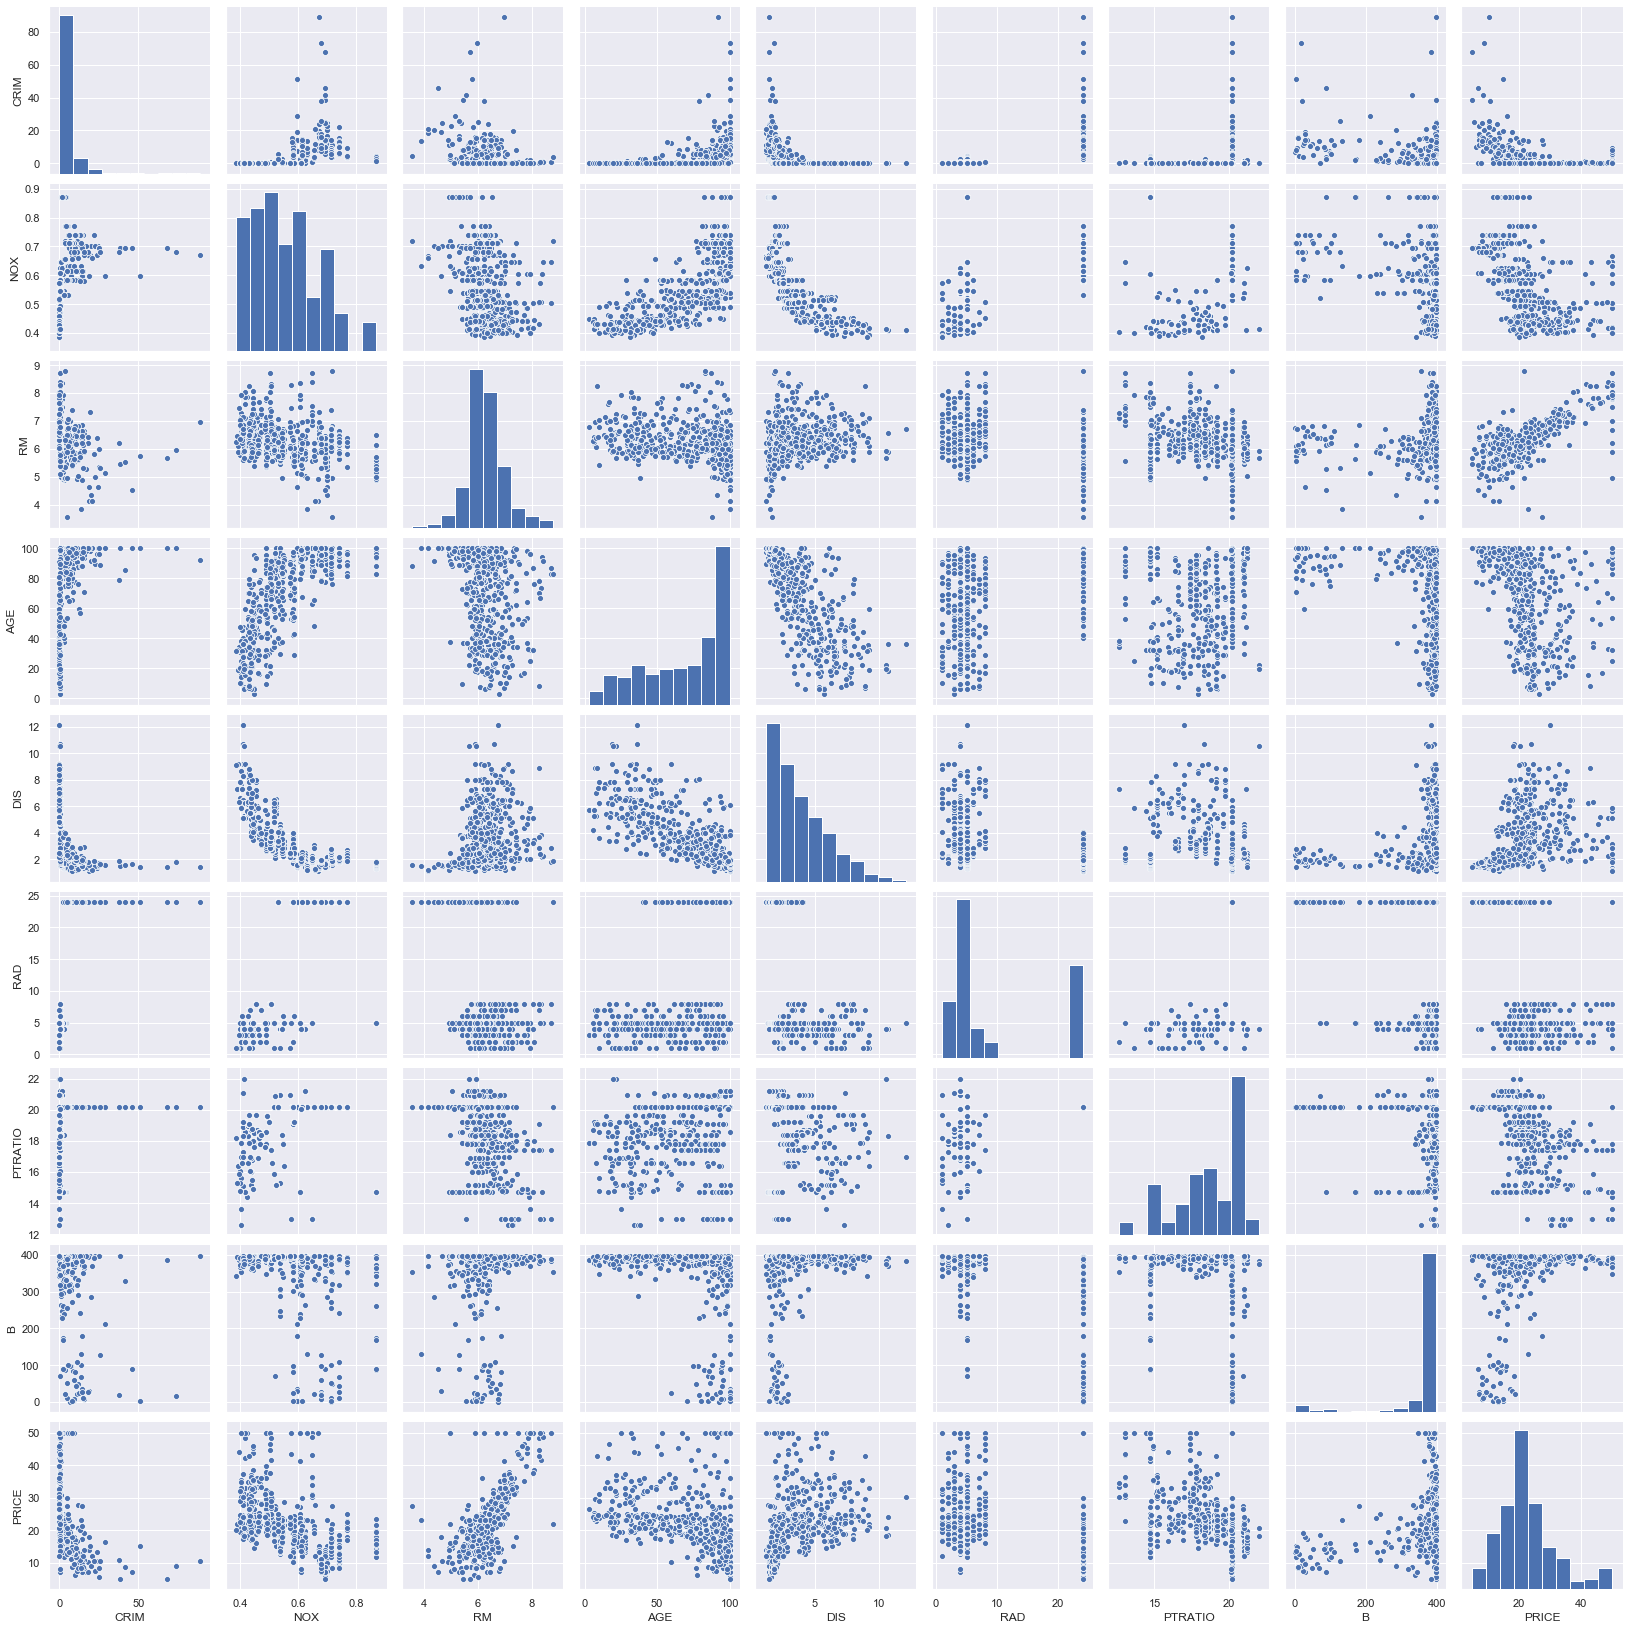

In [4]:
sns.pairplot(df[["CRIM","NOX","RM","AGE","DIS","RAD","PTRATIO","B","PRICE"]])
plt.show()

## Self coded

### Helper Functions

In [5]:
tt = lambda var: torch.tensor(var).float()


def init_params(X):
    return torch.rand(X.shape[1]).reshape(-1, 1)


def add_poly(X):
    return tt(PolynomialFeatures().fit_transform(X))


def hyp(X, p):
    return X @ p


def loss(y_p, y):
    return torch.pow((y_p - y), 2)


def regu(p, lamb):
    return lamb * torch.norm(p)


def cost(y, p, y_p, lamb):
    ls = loss(y_p, y)
    l2 = regu(p, lamb)
    return (ls.sum() + l2) / (2 * y.shape[0])

### Gradient Descent

In [6]:
def fit(X, y, p, epochs=1000,  alpha=1e-2, lamb=1e-4, delta=1e-3):
    costs = []
    prev_cst = 0
    
    # Switch on gradient calculation.
    for var in [X,y,p]:
        var.requires_grad_(True)
    
    for i in range(epochs):
        
        y_p = hyp(X,p)
        cst = cost(y,p,y_p,lamb)
        costs.append(cst.item())
        
        cst.backward()
        new_p = p - alpha * p.grad
        
#         set_trace()
        with torch.no_grad():
            p.copy_(new_p)
        
        # Set gradients to zero
        for var in [X,y,p]:
            var.grad.data.zero_()
        
        if torch.abs(prev_cst - cst) < delta:
            break
        else:
            prev_cst = cst
            
    # Switch off gradient calculation.
    for var in [X,y,p]:
        var.requires_grad_(False)
    
    return costs

### Main function

ranfor: 2000 iter, max_cost:27627.19140625, min_cost569.5706176757812


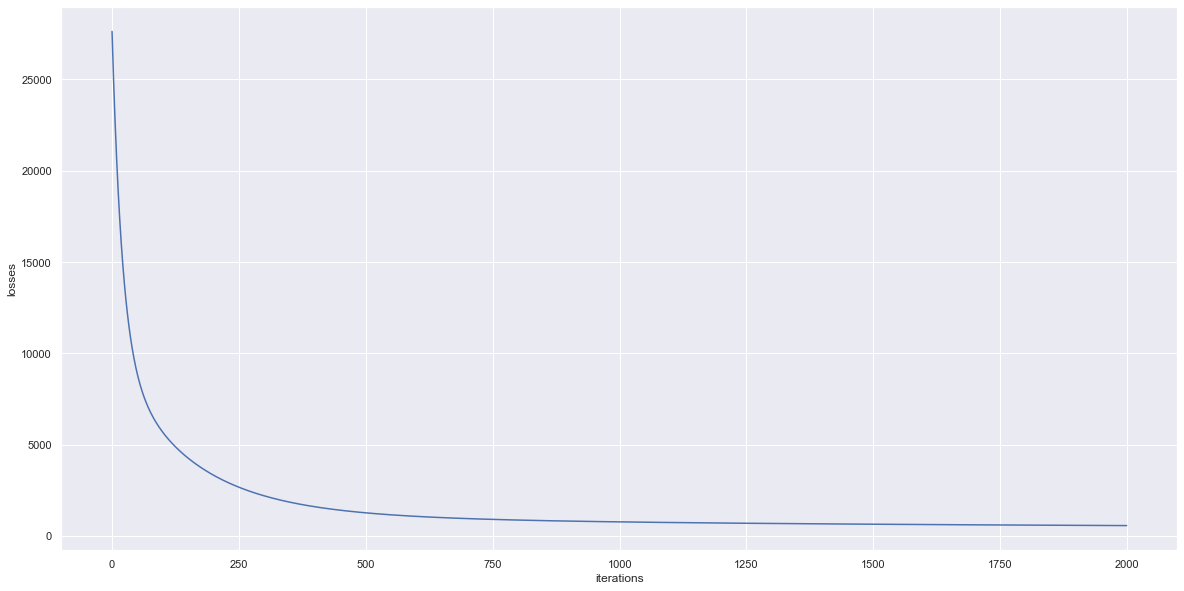

In [7]:
def call_all(X,y):
    X = add_poly(X)
    y = tt(y)
    p = init_params(X)
    
    costs = fit(X,y,p,alpha=1e-6,epochs=2000,lamb=1e-9)
    print(f"ranfor: {len(costs)} iter, max_cost:{max(costs)}, min_cost{min(costs)}")
    ax = sns.lineplot(np.arange(len(costs)),costs,)
    ax.set(xlabel="iterations",ylabel="losses")
    return p
    
params = call_all(X_tr,y_tr)

### Checking test and train losses

In [8]:
def check(X,y,p):
    X = add_poly(X)
    y_p = hyp(X,p)
    return cost(y, p, y_p, 0)

In [9]:
cost_tr = check(X_tr,y_tr,params)
cost_te = check(X_te,y_te,params)
print(f"costs: train {cost_tr}, test {cost_te}")

costs: train 569.447667688705, test 205.0739772835251


## Using sklearn

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
re = LinearRegression()
re.fit(add_poly(X_tr), y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
def check_sk(X,y,re):
    y_p = re.predict(add_poly(X)).reshape(-1,1)
    return ((y-y_p)**2).sum()/(2*y.shape[0])

In [13]:
cost_tr = check_sk(X_tr,y_tr,re)
cost_te = check_sk(X_te,y_te,re)
print(f"costs: train {cost_tr}, test {cost_te}")

costs: train 389.25582341430714, test 103.5477922937012
